# Demo: Calibration Directly using Simulator (no emulator in MCMC)

- Author: Arthur Lui
- Email: alui@lanl.gov
- Date: 18 Feb, 2022

## Introduction
This notebook demonstrates how model calibration can be done in SEPIA directly using a computer model, i.e. without an emulator.
Discrepancy can be incorporated, and (function, observational, and discrepancy) predictions can be made at new locations (`x`), given the inferred
(SEPIA) model and physical parameters.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Control number of threads for linear algebra operations.
# Probably need only one of these, but these should cover it.

import os
os.environ['OPENBLAS_NUM_THREADS'] = '8'
os.environ['MKL_NUM_THREADS'] = '8'
os.environ['NUMEXPR_NUM_THREADS'] = '8'
os.environ['OPENBLAS_MAIN_FREE'] = '8'

In [3]:
# Other library imports.

import sepia
from sepia import SepiaData, SepiaModel
from sepia.contrib.emufree_calib_model import DBasis
from sepia.contrib.emufree_calib_model import sqexpkernel
from scipy.linalg import block_diag
from sepia.contrib.ppl import distributions as dist
from sepia.contrib import basis
from sepia.contrib.ppl.distributions import GP
import numpy as np
from sepia.contrib.ppl.util.pbar import pbrange
from sepia.contrib.ppl.inference.util import trim
from scipy.spatial import distance

from sepia.contrib.emufree_calib_model import posterior_predictive

import matplotlib.pyplot as plt
from matplotlib import animation
plt.rcParams["animation.html"] = "html5"  # or jshtml, which results in larger but more interactive graphs.
orig_dpi = 72  # original dpi.

We first construct a toy dataset. We assume a computer model which returns a function. Specifically., a computer model (simulator) $\eta(x, t)$ will take accepts inputs $x$ and $t$ (both possibly vectors) and
returns a vector of outputs (of length $n$). For simplicity in this example, the ($n$) indexing points at which the simulator $\eta$ is evaluated is assumed to be a fixed grid, although it need not be.
The simulator indexing points here is a length-60 regular grid from 0 to 1.

Let the simulator indexing points be $\mathbf s = \{s_1, \dots, s_{60}\}$.
The form of $\eta$ is 
$$\eta_i(x, t) = t + 0.25 \cdot \sin(s_i \cdot 4 \pi) \cdot x$$
such that $\eta(x, t) = [\eta_1(x, t), \dots, \eta_{60}(x, t)]^T$.

The discrepancy captures the differences between observations and simulator at observed inputs $x$ (but not physical parameters $t$).
It's form will be:
$$
\delta_i(x) = \begin{cases}
  (s_i - x ^ {0.2}) \cdot \sqrt{3x + 0.03}, &\text{ if } s_i > x ^ {0.2} \\
  0, &\text{ otherwise.}
\end{cases}
$$

In [4]:
# Simulator gridsize.
sim_gridsize = 60

# Simulator grid.
sim_grid = np.linspace(0, 1, sim_gridsize)

# Simulator.
def eta(x, t):
    return t[0] + 0.25 * np.sin(sim_grid * 4 * np.pi) * x[0]

# Discrepancy.
def delta(x, a=3):
    return np.clip(sim_grid - np.power(x[0], 0.2), 0, np.inf) * np.sqrt((x[0] + 0.01) * a)

With the simulator $\eta$ and discrepancy $\delta$ specified, we generate three observations, where each input $x_i$ is a scalar, the physical parameter $t$ is a scalar, 
and each response $y_i$ is a vector (of length 60, lilke the simulator).

The true discrepancy at each of the values of $x$ (0.2, 0.45, 0.7) are shown in the figure below.

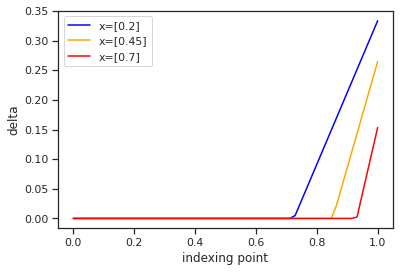

In [5]:
# Generate data.
np.random.seed(0)

num_obs = 3
X = np.linspace(.2, .7, num_obs)[:, None]
theta = np.array([.7])
lam_true = 0.01
a = 7

colors = ["blue", "orange", "red"]
true_discrepancy = [delta(x, a=a) for x in X]
ys = [np.random.normal(eta(x, theta) + delta(x, a=a), lam_true) for x in X]
y = np.concatenate(ys)

for i, x in enumerate(X):
    plt.plot(sim_grid, true_discrepancy[i], label=f"x={x}", color=colors[i])
plt.legend()
plt.xlabel("indexing point")
plt.ylabel("delta")
plt.savefig('img/delta.pdf')
plt.show()

This figure shows the generated response curves (three $y_i$'s) for different input $x_i$'s, given a true underlying $t$ of 0.7.

We will attempt to learn the discrepancy, and $\theta$ using this dataset ($s$, $x$, $y$).

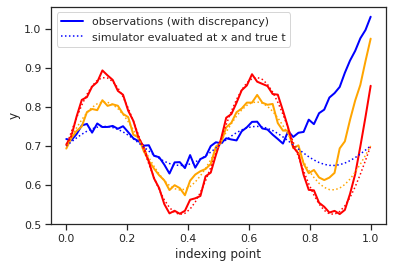

In [6]:
for i, x in enumerate(X):
    # plt.plot(sim_grid, ys[i], lw=3)
    label = None if i > 0 else "observations (with discrepancy)"
    plt.plot(sim_grid, ys[i], label=label, lw=2, color=colors[i])
for i, x in enumerate(X):
    label = None if i > 0 else "simulator evaluated at x and true t"
    plt.plot(sim_grid, eta(x, theta), label=label, ls=":", color=colors[i])
plt.xlabel("indexing point")
plt.ylabel("y")
plt.legend()
plt.savefig('img/data.pdf')
plt.show()

## SEPIA Model for calibration of physical parameters using simulator, with discrepancy

The SEPIA model being fit is

\begin{align*}
\mathbf{y}_i \mid t, \bf{v}, \lambda &\sim \text{MvNormal}(\boldsymbol{\eta}(x_i, t) + \delta(x_i), \lambda ^ 2 \Sigma_i)
\end{align*}

where 
- $\delta(x)$ is a function of the input vector ($x$), and quantifies the discrepancy between the observed $\mathbf{y}_i$ and the simulator's predicted response.
- $\Sigma_i$ is the covariance matrix corresponding to the observation vector $\mathbf{y}_i$. This is assumed to be known.

Since we anticipate that the response vector $\mathbf{y}_i$ is high-dimensional, we will model discrepancy as $\delta(x_i) = D_i \cdot \mathbf{v}(x_i)$, where 
$D_i$ is constructed from a user-selected basis and $\mathbf{v}(x_i)$ is a Gaussian process (GP) evaluated at $x_i$. For example, if elect for $K$ bases to construct $D_i$, and
if $D_i$ is constructed using a radial basis, then given the simulator grid, element $(j, k)$ of the matrix $D_i$ is ${D_i}_{(j,k)} = \exp(-(s_j - \tau_k)^2 / 2\rho^2)/\sqrt{2\pi\rho^2}$,
where $\rho$ is a user-specified length-scale. (A good default is to set $\rho$ such that the basis components are spaced one standard deviation apart.) Other bases can be specified by the user, 
but the radial basis is the default basis, due to its flexibility. Note that $s_j$ and $\tau_k$ refer to the $j$-th simulator grid and $k$-th basis component, respectively. The
number of basis components should not be larger than the simulator grid size.

$v$ is specified as a GP. Note that this allows us to predict at unobserved locations $x^\star$ by interpolation. We assume a squared exponential covariance kernel where the length-scale and
process variance are estimated.

If the structure of $D$ is not specified by the user, no discrepancy is modeled.

For simplicity, the example below assumes both $x_i$ and $t$ are scalars. But $x_i$ and $t$ can be (and usually are) vectors.

In [7]:
# Base sepia data.
sepia_data = SepiaData(x_obs=X, y_obs=ys, theta_dim=1, eta=eta, Sigy=np.eye(y.shape[0]))


# Create D basis.
num_basis = 21
knots = np.linspace(0, 1, num_basis)[:, None]

# Gaussian kernel basis.
# NOTE: Raidal basis kernel width (sd) can influence results. We 
# recommend that the basis components be spaced out by approximately 
# one standard deviation.
Dbasis = DBasis([sim_grid[:, None] for _ in X], knots, sd=1/(num_basis-1))

# If this is not invoked, no discrepancy is modeled.
sepia_data.create_D_basis(Dbasis=Dbasis)

## Initialize model. 

In [8]:
sepia_model = SepiaModel(sepia_data)

## Run MCMC
- get 1000 samples
- after burning for 3000 iterations
- and thinning by every 3
- Note: total number of iterations = burn + num_samples * thinning = 3000 + 1000 * 3 = **6000**.

In [9]:
result = sepia_model.do_mcmc(1000, burn=3000, thinning=3)

[2022-03-29 14:05:38 | ############### | 6000/6000 (100%) | 0:00:26<0:00:00 | 229.28it/s]


In [10]:
print("result.keys(): ", result.keys())
samples = result['samples']

print("samples.keys(): ", samples.keys())

result.keys():  dict_keys(['mcmc', 'samples', 'init_state', 'kernel', 'window', 'burn', 'num_samples', 'thinning'])
samples.keys():  dict_keys(['length_scale', 'process_sd', 't', 'lam'])


## Posterior summaries

Below are marginal posterior summaries of the GP parameters (for $v$),
the multiplier ($\lambda$) for the observation covariance $\Sigma$,
and the physical parameter $t$.

Note that the ground truth for $\lambda$ and $t$ are included in their 95\% credible intervals.

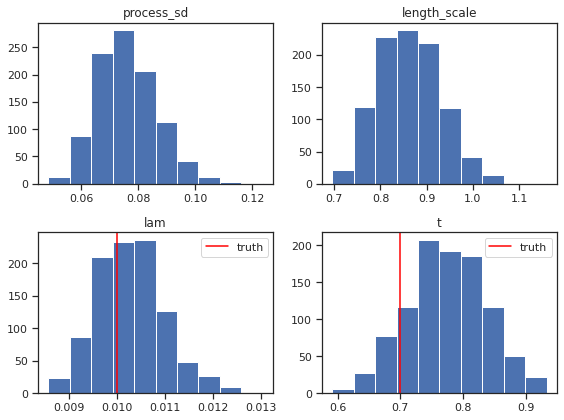

In [11]:
def plot_parameter_posterior(samples):
    plt.figure(figsize=(8, 6))

    plt.subplot(2, 2, 1)
    plt.hist(samples["process_sd"])
    plt.title("process_sd")

    plt.subplot(2, 2, 2)
    plt.hist(samples['length_scale'])
    plt.title("length_scale")
    # plt.xlim(0)

    plt.subplot(2, 2, 3)
    plt.hist(samples['lam'])
    plt.title("lam")
    plt.axvline(lam_true, color="red", label="truth")
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.hist(samples["t"].flatten())
    plt.title("t")
    # plt.xlim(0, 1)
    plt.axvline(theta, color="red", label="truth")
    plt.legend()
    
plot_parameter_posterior(samples)
plt.tight_layout()
plt.savefig("img/radial-basis-posteriors.pdf")
plt.show()

## Predictions at (unobserved) new locations. 

Here, we generate a new set (30) of inputs $x^\star$ at which we want to make predictions.
The `post_pred` object is a dictionary containing 
- the mean function (`mean_fn`), 
- the posterior predictive for a new observation (`predictive`), and
- the predicted discrepancy (`discrepancy`).

In [12]:
# New grid at which to predict.
Xnew = np.sort(np.concatenate([X.flatten(), np.linspace(0, 1, 30)]))[:, None]

# Posterior predictives.
post_pred = posterior_predictive(
    Xnew, Wnew=np.eye(sim_gridsize * Xnew.shape[0]),
    data=sepia_model.emu_free_model_data, post_samples=samples,
    indexing_points=[sim_grid[:, None] for _ in Xnew] # indexing points (for y) at new locations.
)

[2022-03-29 14:06:46 | ############### | 1000/1000 (100%) | 0:01:07<0:00:00 | 14.82it/s]
[2022-03-29 14:06:52 | ############### | 1000/1000 (100%) | 0:00:05<0:00:00 | 184.19it/s]


In [13]:
print(post_pred.keys())
post_delta = post_pred["delta"]  # discrepancy at new locations.
post_y = post_pred["predictive"]  # posterior predictive (at new locations).
post_y.shape, post_delta.shape

dict_keys(['mean_fn', 'predictive', 'delta'])


((1000, 1980), (1000, 1980))

## Plotting results

The following cells shows how we can visualize the results of this analysis.
Extentions to visualize problems where $x$ and $t$ are multivariate are possible, though more challenging.

In [14]:
# For subsetting.
class Subset:
    def __init__(self, size):
        self.size = size
    def get(self, y, i):
        start = self.size * i
        end = start + self.size
        return y[start:end]

# Posterior Predictive Mean Function at (old and) new locations.
def make_plotter(fig, post_y):
    subset = Subset(sim_gridsize)

    def plotter(i, x):
        p = subset.get
        mean = subset.get(post_y.mean(0), i)
        
        if x in X.tolist():
            j = np.argwhere(X == x).flatten()[0]
            plt.scatter(sim_grid, subset.get(y, j), s=10, color="orange", label="data")
            
        plt.plot(sim_grid, mean, lw=3, label="prediction")
        plt.plot(sim_grid, eta(x, theta) + delta(x, a=a), label="truth")

        lower = subset.get(np.quantile(post_y, 0.025, 0), i)
        upper = subset.get(np.quantile(post_y, 0.975, 0), i)
        plt.fill_between(sim_grid, lower, upper, alpha=0.1, color="blue")
        plt.ylim(0.3, 1.1)
        plt.title(f"xobs: {x[0]:.3f}")
        plt.legend(loc="lower left")
        
    return plotter

# Helper to plot posterior at new locations.
def make_delta_plotter(fig, post_delta):
    subset = Subset(sim_gridsize)

    def plotter(i, x):
        mean = subset.get(post_delta.mean(0), i)
        
        plt.plot(sim_grid, mean, lw=3, label="prediction")
        plt.plot(sim_grid, delta(x, a=a), label="truth")

        lower = subset.get(np.quantile(post_delta, 0.025, 0), i)
        upper = subset.get(np.quantile(post_delta, 0.975, 0), i)
        plt.fill_between(sim_grid, lower, upper, alpha=0.1, color="blue")
        plt.ylim(-0.3, 0.3)
        plt.title(f"xobs: {x[0]:.3f}")
        plt.ylabel("discrepancy")
        plt.legend(loc="lower left")
        
    return plotter

# Posterior predictive distribution (y at new locations)

The dots represent the data. The blue line is the posterior predictive mean, and the blue region is 
the 95\% credible interval. The orange curve is the ground truth. Note that the blue and orange
curves generally match where we have data, and interpolation between observations is reasonable.
Extrapolation (outside of the observed $x$'s) is challenging and results from extrapolation
should be scrutinized further.

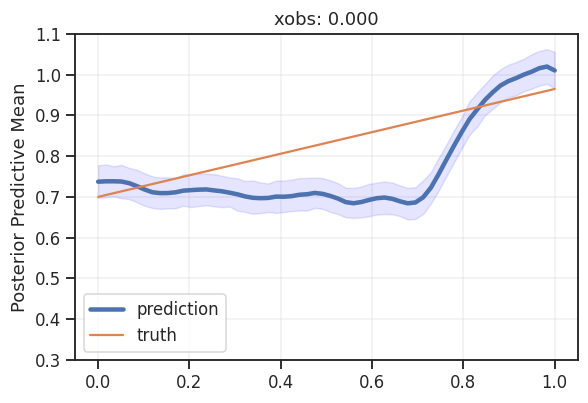

In [15]:
# Increase resolution.
plt.rcParams['figure.dpi'] = orig_dpi * 1.5

fig, ax = plt.subplots()
plotter = make_plotter(fig, post_y)

def animate(t):
    plt.cla();
    plotter(t, Xnew[t]);
    plt.grid(lw=0.3);
    plt.ylabel("Posterior Predictive Mean")
    
def make_reversing_frames(n):
    frames = np.arange(n)
    return np.concatenate([frames, frames[::-1]])

frames = make_reversing_frames(len(Xnew))
anim = animation.FuncAnimation(fig, animate, frames=frames, interval=120)
plt.rcParams['figure.dpi'] = orig_dpi

# NOTE: This video cannot be viewed on GitHub, but you can view it on nbviewer.
anim

In [35]:
# Save output.
save_locations = Xnew[[2, 6, 10, 15, 19, 23, 27]].flatten()
print(save_locations)
# gridplot_figsize = (5,5)
gridplot_figsize = (3, 3)

for i, x in enumerate(Xnew):
    if x in save_locations:
        fig = plt.figure(figsize=gridplot_figsize)
        plotter = make_plotter(fig, post_y)
        plotter(i, x)
        plt.ylabel("posterior predictive mean")
        plt.savefig(f'img/post-pred-radial-{x[0]:.3f}.pdf', bbox_inches="tight")
        plt.close()

[0.06896552 0.2        0.31034483 0.45       0.5862069  0.7
 0.82758621]


# Posterior predictive distribution of the discrepancy (at new locations)

Below are visualizations of the discrepancy at different inputs. Again,
the blue and orange curves generally match when we interpolate over the observed
inputs. Note that the uncertainty is quite large as confounding with $t$ occurs.

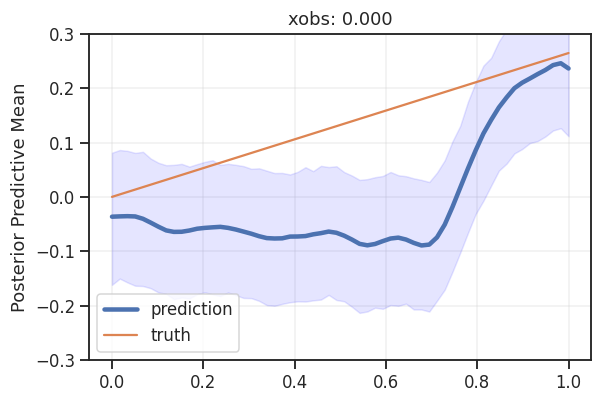

In [36]:
plt.rcParams['figure.dpi'] = orig_dpi * 1.5

fig, ax = plt.subplots()
plotter = make_delta_plotter(fig, post_delta)
frames = make_reversing_frames(len(Xnew))
anim = animation.FuncAnimation(fig, animate, frames=frames, interval=120)
plt.rcParams['figure.dpi'] = orig_dpi

# NOTE: This video cannot be viewed on GitHub, but you can view it on nbviewer.
anim

In [37]:
# Save output.
for i, x in enumerate(Xnew):
    if x in save_locations:
        fig = plt.figure(figsize=gridplot_figsize)
        plotter = make_delta_plotter(fig, post_delta)
        plotter(i, x)
        plt.ylabel("posterior predictive mean")
        plt.savefig(f'img/post-pred-delta-radial-{x[0]:.3f}.pdf', bbox_inches="tight")
        plt.close()

# Redo Analysis with Hinge Basis

The cells below demonstrate how the analysis can be done with a different 
basis function for the discrepancy. All that really needs to be modified
is the `basis` argument in `DBasis`.

Since we know the form of the basis in this model is a hinge function, 
we can construct $D$ using hinge basis components. We expect that 
this added information should decrease uncertainty and lead to better
recovery of $t$.

In [38]:
# Sepia data object.
sepia_data_hinge = SepiaData(x_obs=X, y_obs=ys, theta_dim=1, eta=eta, Sigy=np.eye(y.shape[0]))

# Hinge function (as implemented in SEPIA as `sepia.contrib.basis.hinge`.)
def hinge(x, knots):
    return np.maximum(x - knots.T, 0)

# Hinge basis.
Dbasis_hinge = DBasis(
    [sim_grid[:, None] for _ in X],
    knots, basis=hinge,
    normalize=False, bias=False
)

# Alternatively, we can use the hinge function supplied by SEPIA.
# Dbasis_hinge = DBasis(
#     [sim_grid[:, None] for _ in X],
#     knots, basis=basis.hinge,
#     normalize=False, bias=False
# )

# Register the hinge basis for Sepia data object.
sepia_data_hinge.create_D_basis(Dbasis=Dbasis_hinge)

# Sepia Model.
sepia_model_hinge = SepiaModel(sepia_data_hinge)

# Fit model with MCMC.
result_hinge = sepia_model_hinge.do_mcmc(1000, burn=3000, thinning=3)
samples_hinge = result_hinge['samples']

[2022-03-29 15:13:17 | ############### | 6000/6000 (100%) | 0:00:25<0:00:00 | 233.70it/s]


**Other Bases (currently implemented)**

Additional arguments for the basis function can be supplied to DBasis. For example, the following basis functions
are implemented in SEPIA (as `sepia.contrib.basis.constant` and `sepia.contrib.basis.window`). The implementations 
in SEPIA are more general as `x` and `knots` are assumed to be column vectors below; whereas `x` and `knots`
can be matrices in `sepia.contrib.basis`. Note that `hinge` is implemented in `sepia.contrib.basis` but 
is required to be a column vector.

```python
def constant(x, knots):
    return np.ones([x.shape[0], knots.shape[0]])
Dbasis_constant = DBasis([sim_grid[:, None] for _ in X], knots, basis=constant, normalize=False, bias=False)

def window(x, knots, width):
    diff = x - knots.T
    return np.abs(diff) < width
Dbasis_window = DBasis([sim_grid[:, None] for _ in X], knots, basis=window, normalize=False, bias=True, width=1/(num_basis-1))
```

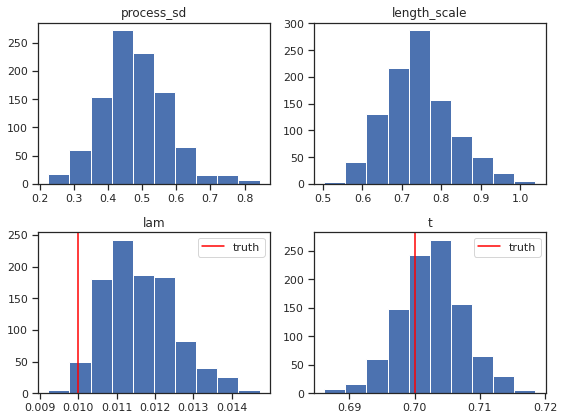

In [39]:
# Plot posterior samples.
plot_parameter_posterior(samples_hinge)
plt.tight_layout()
plt.savefig("img/hinge-basis-posteriors.pdf")
plt.show()

# Posterior predictives.

In [40]:
post_pred_hinge = posterior_predictive(
    Xnew, Wnew=np.eye(sim_gridsize * Xnew.shape[0]),
    data=sepia_model_hinge.emu_free_model_data,
    post_samples=trim(samples_hinge, thin=2),  # Can trim posterior samples (e.g. burn, thin).
    indexing_points=[sim_grid[:, None] for _ in Xnew] # indexing points (for y) at new locations.
)

# Posterior predictive for the discrepancy function.
post_delta_hinge = post_pred_hinge["delta"]  # discrepancy at new locations.

# Full posterior predictive for observations.
post_y_hinge = post_pred_hinge["predictive"]  # posterior predictive (at new locations).

[2022-03-29 15:13:48 | ############### | 500/500 (100%) | 0:00:30<0:00:00 | 16.65it/s]
[2022-03-29 15:13:50 | ############### | 500/500 (100%) | 0:00:02<0:00:00 | 187.01it/s]


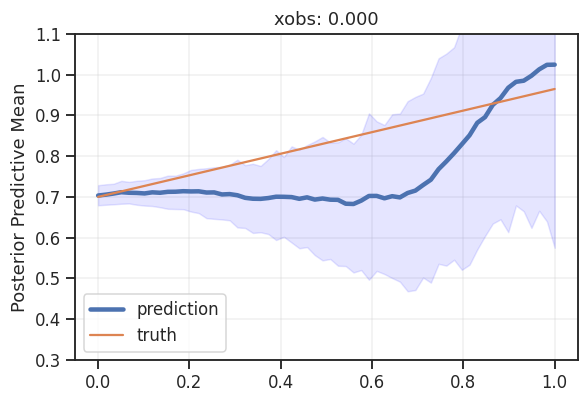

In [41]:
# Increase resolution.
plt.rcParams['figure.dpi'] = orig_dpi * 1.5

fig, ax = plt.subplots()
plotter = make_plotter(fig, post_y_hinge)
# plotter = make_plotter(fig, post_pred_hinge['mean_fn'])
frames = make_reversing_frames(len(Xnew))
anim = animation.FuncAnimation(fig, animate, frames=frames, interval=120)
plt.rcParams['figure.dpi'] = orig_dpi

# NOTE: This video cannot be viewed on GitHub, but you can view it on nbviewer.
anim

In [42]:
# Save output.
for i, x in enumerate(Xnew):
    if x in save_locations:
        fig = plt.figure(figsize=gridplot_figsize)
        plotter = make_plotter(fig, post_y_hinge)
        plotter(i, x)
        plt.ylabel("posterior predictive mean")
        plt.savefig(f'img/post-pred-hinge-{x[0]:.3f}.pdf', bbox_inches="tight")
        plt.close()

# Posterior predictive of discrepancy.

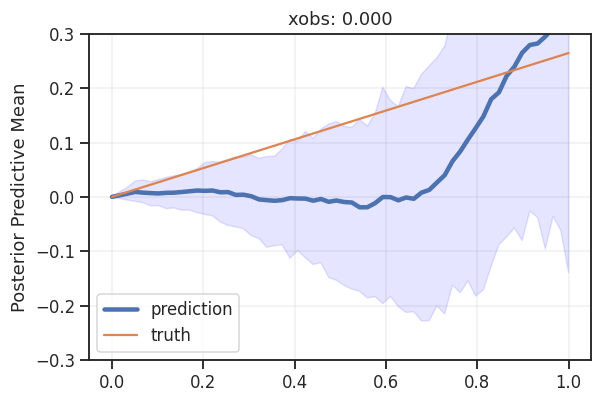

In [43]:
plt.rcParams['figure.dpi'] = orig_dpi * 1.5

fig, ax = plt.subplots()
plotter = make_delta_plotter(fig, post_delta_hinge)
frames = make_reversing_frames(len(Xnew))
anim = animation.FuncAnimation(fig, animate, frames=frames, interval=120)
plt.rcParams['figure.dpi'] = orig_dpi

# NOTE: This video cannot be viewed on GitHub, but you can view it on nbviewer.
anim

In [44]:
# Save output.
for i, x in enumerate(Xnew):
    if x in save_locations:
        fig = plt.figure(figsize=gridplot_figsize)
        plotter = make_delta_plotter(fig, post_delta_hinge)
        plotter(i, x)
        plt.ylabel("posterior predictive mean")
        plt.savefig(f'img/post-pred-delta-hinge-{x[0]:.3f}.pdf', bbox_inches="tight")
        plt.close()

# Redo without discrepancy

Finally, we will ignore model discrepancy. We expect that without modeling discrepancy, the simulator alone cannot captrue 
all the signal from the data, leading to underfitting. Predictive uncertainty is large in this case. At the same time, 
uncertainties for $t$, however, are relatively small and biased. i.e., we are confident in a wrong value for $t$.

In [45]:
# Sepia data object.
sepia_data_nodelta = SepiaData(x_obs=X, y_obs=ys, theta_dim=1, eta=eta, Sigy=np.eye(y.shape[0]))

# Sepia Model.
sepia_model_nodelta = SepiaModel(sepia_data_nodelta)

# Note that we have note invoked sepia_data.create_D_basis.
# Thus, discrepancy is not modeled.

# Fit model with MCMC.
result_nodelta = sepia_model_nodelta.do_mcmc(1000, burn=3000, thinning=3)
samples_nodelta = result_nodelta['samples']

[2022-03-29 15:14:28 | ############### | 6000/6000 (100%) | 0:00:21<0:00:00 | 274.46it/s]


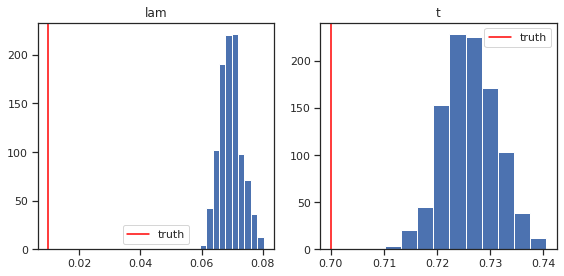

In [46]:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.hist(samples_nodelta['lam'])
plt.title("lam")
plt.axvline(lam_true, color="red", label="truth")
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(samples_nodelta["t"].flatten())
plt.title("t")
plt.axvline(theta, color="red", label="truth")
plt.legend()

plt.tight_layout()
plt.savefig("img/nodelta-posteriors.pdf")

plt.show()

In [47]:
# Posterior predictives.
post_pred_nodelta = posterior_predictive(
    Xnew, Wnew=np.eye(sim_gridsize * Xnew.shape[0]),
    data=sepia_model_nodelta.emu_free_model_data,
    post_samples=samples_nodelta,
    indexing_points=[sim_grid[:, None] for _ in Xnew] # indexing points (for y) at new locations.
)

# No posterior predictive for the discrepancy function.

# Full posterior predictive for observations.
post_y_nodelta = post_pred_nodelta["predictive"]  # posterior predictive (at new locations).

[2022-03-29 15:14:28 | ############### | 1000/1000 (100%) | 0:00:00<0:00:00 | 4137.32it/s]
[2022-03-29 15:14:34 | ############### | 1000/1000 (100%) | 0:00:05<0:00:00 | 173.27it/s]


# Posterior predictive at new locations.

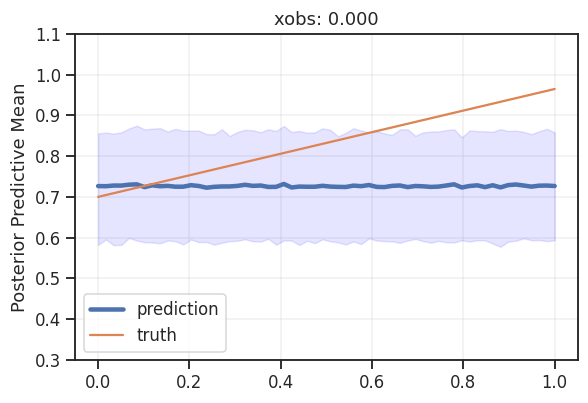

In [48]:
# Increase resolution.
plt.rcParams['figure.dpi'] = orig_dpi * 1.5

fig, ax = plt.subplots()
plotter = make_plotter(fig, post_y_nodelta)
frames = make_reversing_frames(len(Xnew))
anim = animation.FuncAnimation(fig, animate, frames=frames, interval=120)
plt.rcParams['figure.dpi'] = orig_dpi

# NOTE: This video cannot be viewed on GitHub, but you can view it on nbviewer.
anim

In [49]:
# Save output.
for i, x in enumerate(Xnew):
    if x in save_locations:
        fig = plt.figure(figsize=gridplot_figsize)
        plotter = make_plotter(fig, post_y_nodelta)
        plotter(i, x)
        plt.ylabel("posterior predictive mean")
        plt.savefig(f'img/post-pred-nodelta-{x[0]:.3f}.pdf', bbox_inches="tight")
        plt.close()